*Cluster-Based Toxicity Estimation of Osteoradionecrosis via Unsupervised Machine Learning: Moving Beyond Single Dose-Parameter Normal Tissue Complication Probability by Using Whole Dose-Volume Histograms for Cohort Risk Stratification*

**Copyright (c) 2023 Seyedmohammadhossein Hosseinian. All rights reserved.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn import svm
import csv

In [2]:
#Data input
data = pd.read_csv('ORN_data.csv')
data_DVH = data.iloc[:, 5:]

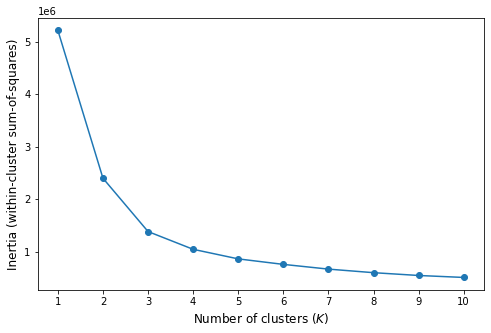

In [3]:
#Clustering inertia
no_clusters = range(1,11)
inertia = []
for n in no_clusters:
    km = KMeans( n_clusters = n, random_state=2)
    km = km.fit(data_DVH)
    ine = km.inertia_
    inertia.append(ine)
figure(figsize=(8, 5))
x = range(1,11)
plt.plot(x, inertia, marker = 'o',linewidth=1.5)
plt.xticks(x)
plt.xlabel('Number of clusters ($K$)',size=12)
plt.ylabel('Inertia (within-cluster sum-of-squares)',size=12)
plt.savefig("Output/inertia.pdf")

In [4]:
numclusters = 6

Cluster [red] size = 165
Cluster [blue] size = 462
Cluster [magenta] size = 76
Cluster [black] size = 130
Cluster [cyan] size = 67
Cluster [green] size = 359


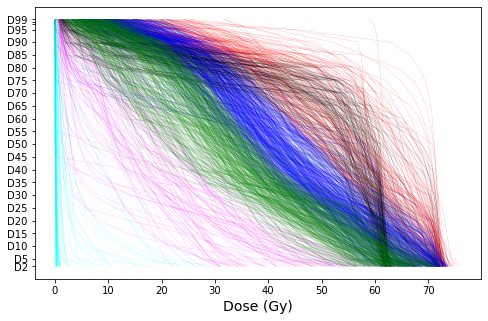

What is the color of the overlapping cluster? black

Excluding the overlapping cluster, enter the color of the remaining clusters from top to bottom.
Color of 1st cluster from the top: red
Color of 2nd cluster from the top: blue
Color of 3th cluster from the top: green
Color of 4th cluster from the top: magenta
Color of 5th cluster from the top: cyan


In [5]:
#Clustering output
km = KMeans(n_clusters=numclusters, random_state=40)
km = km.fit(data_DVH)
clus = km.predict(data_DVH)
centroids = km.cluster_centers_
clusters = []
CL = []
ind = []
for i in range(numclusters):
    clusters.append(data_DVH[clus == i])
    CL.append(pd.DataFrame.to_numpy(clusters[i]))
    ind.append(np.array(clusters[i].index))
#
dose = [2,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,97,98,99]
colors = ['red','blue','magenta','black','cyan','green','yellow','white']
#
for i in range(numclusters):
    print('Cluster ['+str(colors[i])+'] size = '+str(len(ind[i])))
#
figure(figsize=(8, 5))
for k in range(numclusters):
    for i in range(len(ind[k])):
        plt.plot(CL[k][i],dose,color=colors[k],linewidth=0.1)
plt.xlabel("Dose (Gy)",size=14)
plt.yticks(dose,['D2','D5','D10','D15','D20','D25','D30','D35','D40','D45','D50','D55','D60','D65','D70','D75','D80','D85','D90','D95','','','D99'])
plt.savefig("Output/clusters_6.png")
plt.show()
#
dic = {}
for i in range(numclusters):
    dic[str(colors[i])] = i
number_list = []
overlapping = input("What is the color of the overlapping cluster? ")
print("\nExcluding the overlapping cluster, enter the color of the remaining clusters from top to bottom.")
color_ord = []
for i in range(numclusters - 1):
    if i == 0:
        color_input = input(f"Color of {str(i+1)}st cluster from the top: ").lower() 
    elif i == 1:
        color_input = input(f"Color of {str(i+1)}nd cluster from the top: ").lower() 
    else:
        color_input = input(f"Color of {str(i+1)}th cluster from the top: ").lower() 
    # Check if the entered color is in the dictionary
    if color_input in dic:
        number_list.append(str(dic[color_input]))
        color_ord.append(color_input)
    else:
        print(f"Color '{color_input}' not found in the dictionary. Try again.")
        if i == 0:
            color_input = input(f"Color of {str(i+1)}st cluster from the top: ").lower() 
        elif i == 1:
            color_input = input(f"Color of {str(i+1)}nd cluster from the top: ").lower() 
        else:
            color_input = input(f"Color of {str(i+1)}th cluster from the top: ").lower() 
        if color_input in dic:
            number_list.append(str(dic[color_input]))
            color_ord.append(color_input)
        else:
            print(f"Color '{color_input}' not found in the dictionary.") 
            print("\n**************************")
            print("  RESTART THE KERNEL!!!!")
            print("**************************")
            break
color_ord.append(overlapping)
order = ''.join(number_list)

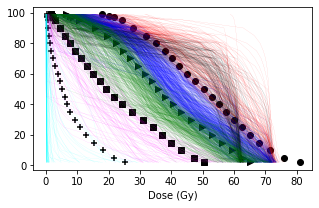

In [6]:
#Finding cluster dividers by SVM
divider = []
for r in range(len(order)-1):
    D = []
    set1 = []
    set2 = []
    for i in range(len(dose)):
        temp = []
        for j in range(len(CL[int(order[r])])):
            temp.append(CL[int(order[r])][j][i])
        set1.append(temp)
        temp = []
        for j in range(len(CL[int(order[r+1])])):
            temp.append(CL[int(order[r+1])][j][i])
        set2.append(temp)
        x1 = np.array([[j,0] for j in set1[i]])
        y1 = np.zeros(len(x1))
        x2 = np.array([[j,0] for j in set2[i]])
        y2 = np.ones(len(x2))
        X = np.concatenate((x1,x2))
        Y = np.concatenate((y1,y2))
        model = svm.LinearSVC(max_iter=int(1e6)).fit(X, Y)
        a1 = model.coef_[0][0]
        a0 = model.intercept_
        d = - a0 / a1
        D.append(d)
    divider.append(D)
figure(figsize=(5, 3))    
for k in range(numclusters):
    for i in range(len(ind[k])):
        plt.plot(CL[k][i],dose,color=colors[k],linewidth=0.05)
    plt.xlabel("Dose (Gy)")
mks = ["o",">","s","+","x","d"]
for i in range(len(divider)):
    plt.scatter(divider[i],dose,color="black",marker=mks[i])

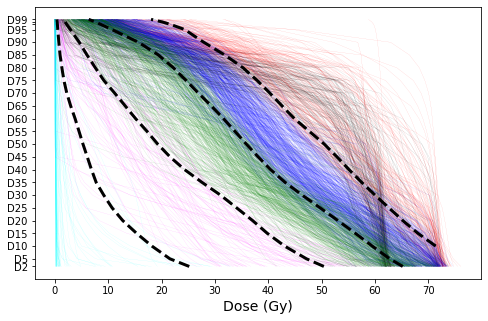

In [7]:
#Setting appropriate domains for the separator lines
figure(figsize=(8, 5))    
for k in range(numclusters):
    for i in range(len(ind[k])):
        plt.plot(CL[k][i],dose,color=colors[k],linewidth=0.05)
    plt.xlabel("Dose (Gy)",size=14)
dose_divider0 = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,97,98,99]
divider_0 = divider[0][2:23]
for i in range(len(divider)):
    if i == 0:
        plt.plot(divider_0,dose_divider0,color="black",linewidth=3,linestyle='--')
    else:
        plt.plot(divider[i],dose,color="black",linewidth=3,linestyle='--')
plt.yticks(dose,['D2','D5','D10','D15','D20','D25','D30','D35','D40','D45','D50','D55','D60','D65','D70','D75','D80','D85','D90','D95','','','D99'])
plt.savefig("Output/separate_6.png")

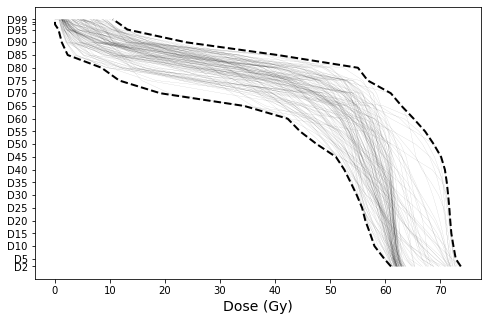

In [8]:
#Plotting the overlapping cluster separately with its envelopes
blackmin=[]
blackmax=[]
figure(figsize=(8, 5))    
for k in range(numclusters):
    if colors[k] == overlapping:   
        for i in range(len(ind[k])):
            plt.plot(CL[k][i],dose,color=colors[k],linewidth=0.05)
        for h in range(len(dose)):
            temp=[]
            for i in range(len(ind[k])): 
                temp.append(CL[k][i][h])
            nptemp = np.array(temp)
            blackmin.append(np.amin(nptemp))
            blackmax.append(np.amax(nptemp))            
        plt.plot(blackmin,dose,color="black",linewidth=2,linestyle='--')
        plt.plot(blackmax,dose,color="black",linewidth=2,linestyle='--')
        plt.xlabel("Dose (Gy)",size=14)
        plt.yticks(dose,['D2','D5','D10','D15','D20','D25','D30','D35','D40','D45','D50','D55','D60','D65','D70','D75','D80','D85','D90','D95','','','D99'])
        plt.savefig("Output/separate_6_black.png")

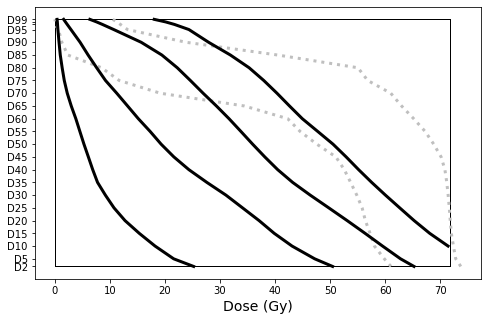

In [9]:
#Partitioning output
figure(figsize=(8, 5)) 
plt.plot([71.75 for i in dose],dose,color='black',linewidth=1)
plt.plot([0 for i in dose],dose,color='black',linewidth=1)
plt.plot([0,71.75],[dose[0],dose[0]],color='black',linewidth=1)
plt.plot([0,71.75],[dose[-1],dose[-1]],color='black',linewidth=1)
plt.plot(blackmin,dose,color='0.75',linewidth=3,linestyle='dotted')
plt.plot(blackmax,dose,color='0.75',linewidth=3,linestyle='dotted')
plt.xlabel("Dose (Gy)",size=14)
plt.yticks(dose,['D2','D5','D10','D15','D20','D25','D30','D35','D40','D45','D50','D55','D60','D65','D70','D75','D80','D85','D90','D95','','','D99'])
for i in range(len(divider)):
    if i == 0:
        plt.plot(divider_0,dose_divider0,color="black",linewidth=3)
    else:
        plt.plot(divider[i],dose,color="black",linewidth=3)
plt.savefig("Output/region_6.png")

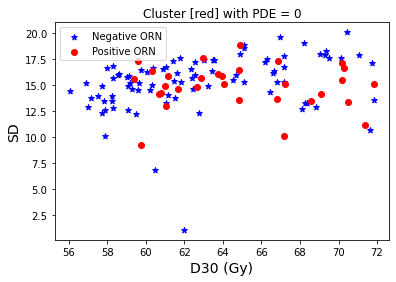

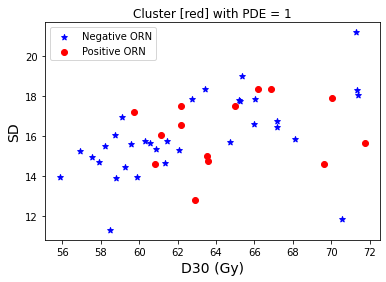

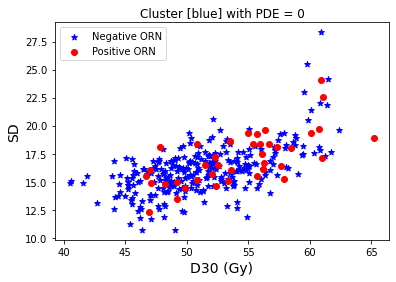

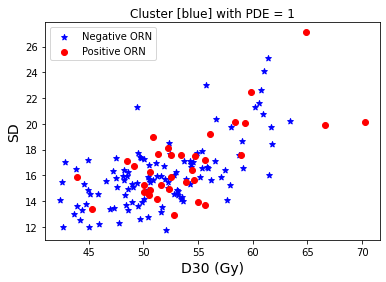

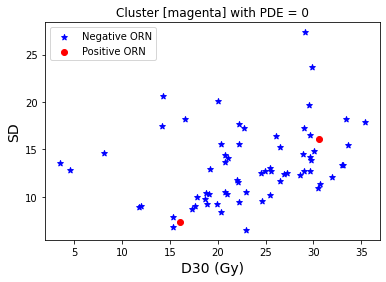

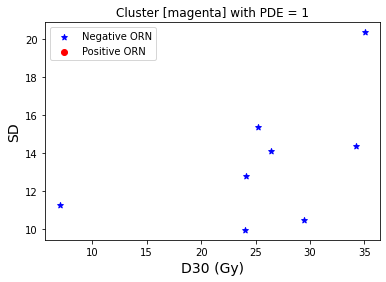

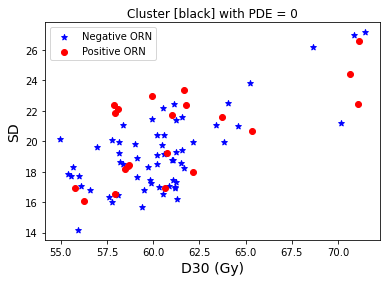

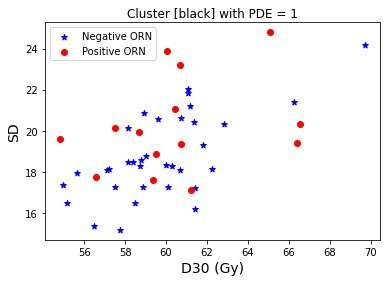

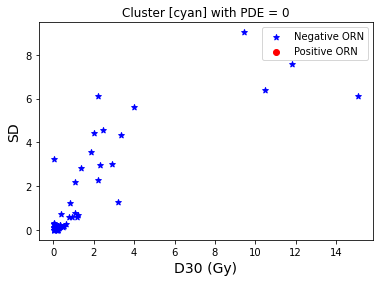

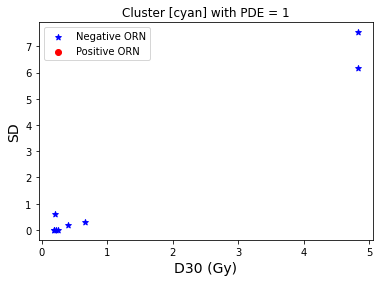

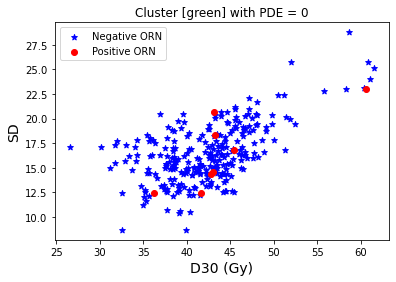

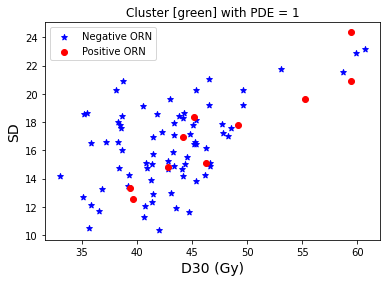

In [10]:
#ORN incidence associated with (DVregion,PDE) pairs
table_train=pd.DataFrame.to_numpy(data)
finalclusters = []
for k in range(numclusters):   
    tempcluster = []
    for i in range(len(ind[k])):
        temp = table_train[ind[k][i],[1,2,3,4,11]]
        temp = [int(temp[0]),np.round(temp[1],2),np.round(temp[2],2),int(temp[3]),np.round(temp[4],2)]
        tempcluster.append(temp)            
    finalclusters.append(tempcluster)
#
TRAINout=[]
for k in range(numclusters):    #In Dxy and Vxy: x=ORN(0/1) and y=PDE(0/1)
    D00=[]    
    V00=[]
    D01=[]
    V01=[]
    D10=[]
    V10=[]
    D11=[]
    V11=[]
    for i in range(len(finalclusters[k])):
        if finalclusters[k][i][0] == 0:
            if finalclusters[k][i][3] == 0:
                D00.append(finalclusters[k][i][4])
                V00.append(np.sqrt(finalclusters[k][i][2]))
            else:
                D01.append(finalclusters[k][i][4])
                V01.append(np.sqrt(finalclusters[k][i][2]))         
        else:
            if finalclusters[k][i][3] == 0:
                D10.append(finalclusters[k][i][4])
                V10.append(np.sqrt(finalclusters[k][i][2]))
            else:
                D11.append(finalclusters[k][i][4])
                V11.append(np.sqrt(finalclusters[k][i][2])) 
    temp = []
    temp.append('PDE = 0:   Incidence rate = '+str(np.round((len(D10)/(len(D00)+len(D10)))*100,1))+' % ('+str(len(D10))+' out of '+str((len(D00)+len(D10)))+')')
    temp.append('PDE = 1:   Incidence rate = '+str(np.round((len(D11)/(len(D01)+len(D11)))*100,1))+' % ('+str(len(D11))+' out of '+str((len(D01)+len(D11)))+')')
    TRAINout.append(temp)
    figure(figsize=(6, 4))
    plt.title('Cluster ['+colors[k]+'] with PDE = 0')
    plt.xlabel("D30 (Gy)",size=14)
    plt.ylabel("SD",size=14)
    plt.scatter(D00,V00,color='blue',marker='*')
    plt.scatter(D10,V10,color='red')
    plt.legend(['Negative ORN', 'Positive ORN'])
    plt.savefig('Output/insepar_6_'+'cluster_'+colors[k]+'_PDE=0.png')
    figure(figsize=(6, 4))
    plt.title('Cluster ['+colors[k]+'] with PDE = 1')
    plt.xlabel("D30 (Gy)",size=14)
    plt.ylabel("SD",size=14)
    plt.scatter(D01,V01,color='blue',marker='*')
    plt.scatter(D11,V11,color='red')
    plt.legend(['Negative ORN', 'Positive ORN'])
    plt.savefig('Output/insepar_6_'+'cluster_'+colors[k]+'_PDE=1.png')

In [11]:
#Output risk indices
g = -1
for c in color_ord:
    for k in range(numclusters):
        if c == colors[k]:
            g += 1
            print('************************************************************************')
            print('Cluster color = '+colors[k])
            print('************************************************************************')
            print(TRAINout[k][0])
            print(TRAINout[k][1])
            print('________________________________________________________________________\n')

************************************************************************
Cluster color = red
************************************************************************
PDE = 0:   Incidence rate = 26.3 % (31 out of 118)
PDE = 1:   Incidence rate = 29.8 % (14 out of 47)
________________________________________________________________________

************************************************************************
Cluster color = blue
************************************************************************
PDE = 0:   Incidence rate = 12.3 % (39 out of 318)
PDE = 1:   Incidence rate = 23.6 % (34 out of 144)
________________________________________________________________________

************************************************************************
Cluster color = green
************************************************************************
PDE = 0:   Incidence rate = 2.9 % (8 out of 273)
PDE = 1:   Incidence rate = 11.6 % (10 out of 86)
_________________________________________________